# EPL Match Winner Prediction Pipeline

This notebook mirrors the README workflow while letting you interactively inspect data, features, and model performance.

**Pipeline Steps**
1. Environment & Imports
2. Download Raw Data (last N seasons)
3. Prepare / Build Features
4. Inspect Engineered Feature Set (schema, sample, distributions, correlations)
5. Train Models (Logistic Regression / HistGradientBoosting)
6. Evaluate (metrics, classification report, confusion matrix, per-class F1, ROC-AUC macro)
7. Hyperparameter Tuning (optional quick examples)
8. Auto-Select Best Model (macro F1, tiebreak accuracy)
9. Save / Load & Sanity Check Prediction Example

Each step can be re-run independently; cells keep paths under `data/processed` and `artifacts/` consistent with the CLI commands.


In [11]:
# 1. Environment & Imports
from __future__ import annotations

import json
import os
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)
import seaborn as sns
import matplotlib.pyplot as plt

# Project modules (assumes editable install or src on PYTHONPATH)
from pemw import data as data_mod
from pemw import features as features_mod
from pemw import model as model_mod

RAW_DIR = Path("data/raw")
PROC_DIR = Path("data/processed")
ARTIFACTS_DIR = Path("artifacts")
PROC_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

SEASONS = 5  # adjustable: number of past seasons to pull
RANDOM_STATE = 42

print(f"Using seasons={SEASONS}")

Using seasons=5


In [12]:
# 2. Download Raw Data & 3. Prepare Features
# (Idempotent: safe to re-run)

# Ensure directories exist
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROC_DIR.mkdir(parents=True, exist_ok=True)

# Download raw match results (CSV files) for last `SEASONS` seasons.
_downloaded = data_mod.download_epl_data(RAW_DIR, seasons=SEASONS)
print(f"Downloaded/validated {_downloaded} season file(s) into {RAW_DIR}")
print("Raw files:")
for p in sorted(RAW_DIR.glob("E0_*.csv")):
    print(" -", p.name, p.stat().st_size, "bytes")

# Build / compute features & write features.parquet
feature_path = features_mod.build_training_table(RAW_DIR, PROC_DIR)
print(f"Features written to {feature_path}")

feature_file = PROC_DIR / "features.parquet"
assert feature_file.exists(), "features.parquet not created"
print("Features file size:", feature_file.stat().st_size, "bytes")

df = pd.read_parquet(feature_file)
print(df.shape)
df.head()

Downloaded/validated 5 season file(s) into data/raw
Raw files:
 - E0_2021.csv 175815 bytes
 - E0_2122.csv 175360 bytes
 - E0_2223.csv 176180 bytes
 - E0_2324.csv 172196 bytes
 - E0_2425.csv 197110 bytes
Features written to data/processed/features.parquet
Features file size: 145199 bytes
(1900, 27)
Features written to data/processed/features.parquet
Features file size: 145199 bytes
(1900, 27)


,Date,Season,HomeTeam,AwayTeam,home_elo,away_elo,elo_diff,exp_home,exp_away,home_form5,...,imp_home,imp_draw,imp_away,target,rest_home,rest_away,AvgH,AvgD,AvgA,elo_prob_gap
0,2020-09-12,2021,Fulham,Arsenal,1500.0,1500.0,0.0,0.585499,0.414501,1.0,...,NaN,NaN,NaN,A,NaN,NaN,5.94,4.34,1.55,0.0
1,2020-09-12,2021,Crystal Palace,Southampton,1500.0,1500.0,0.0,0.585499,0.414501,1.0,...,NaN,NaN,NaN,H,NaN,NaN,3.18,3.22,2.39,0.0
2,2020-09-12,2021,Liverpool,Leeds,1500.0,1500.0,0.0,0.585499,0.414501,1.0,...,NaN,NaN,NaN,H,NaN,NaN,1.30,5.96,9.68,0.0
3,2020-09-12,2021,West Ham,Newcastle,1500.0,1500.0,0.0,0.585499,0.414501,1.0,...,NaN,NaN,NaN,A,NaN,NaN,2.15,3.48,3.42,0.0
4,2020-09-13,2021,West Brom,Leicester,1500.0,1500.0,0.0,0.585499,0.414501,1.0,...,NaN,NaN,NaN,A,NaN,NaN,3.87,3.57,1.97,0.0


## 4. Inspect Engineered Features
Summary statistics, missingness, distributions, correlations.

Columns: 27
Target distribution (target):
target
H    0.432
A    0.340
D    0.228
Name: pct, dtype: float64
Top missing cols:
imp_away     1.000000
imp_draw     1.000000
imp_home     1.000000
rest_home    0.007895
rest_away    0.006316
away_elo     0.000000
home_elo     0.000000
AwayTeam     0.000000
Date         0.000000
Season       0.000000
dtype: float64


,count,mean,std,min,25%,50%,75%,max
home_elo,1900.0,1526.402238,93.474365,1279.708880,1465.387575,1509.231032,1577.685830,1820.726508
away_elo,1900.0,1525.568296,93.786532,1285.950649,1465.855854,1507.711727,1578.419791,1818.496600
elo_diff,1900.0,0.833942,134.073796,-439.984723,-82.443898,1.028890,82.800781,499.517786
exp_home,1900.0,0.576945,0.166028,0.100891,0.467745,0.586935,0.694666,0.961611
exp_away,1900.0,0.423055,0.166028,0.038389,0.305334,0.413065,0.532255,0.899109
home_form5,1900.0,1.375842,0.716407,0.000000,0.800000,1.400000,1.800000,3.000000
away_form5,1900.0,1.402895,0.716924,0.000000,0.800000,1.400000,2.000000,3.000000
home_gd5,1900.0,-0.008368,1.084944,-4.000000,-0.800000,0.000000,0.600000,4.400000
away_gd5,1900.0,0.020018,1.088777,-3.000000,-0.600000,0.000000,0.800000,4.200000
home_form10,1900.0,1.389558,0.600361,0.000000,1.000000,1.400000,1.800000,3.000000


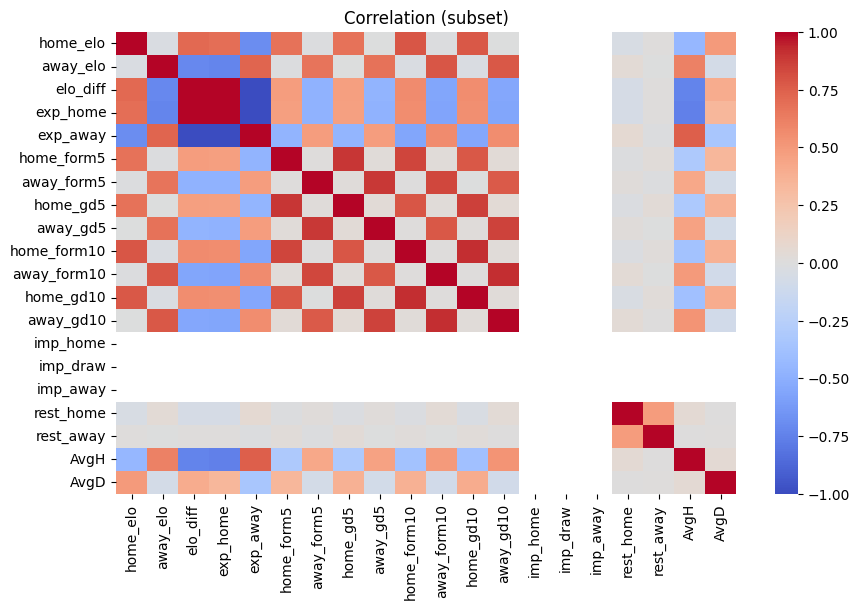

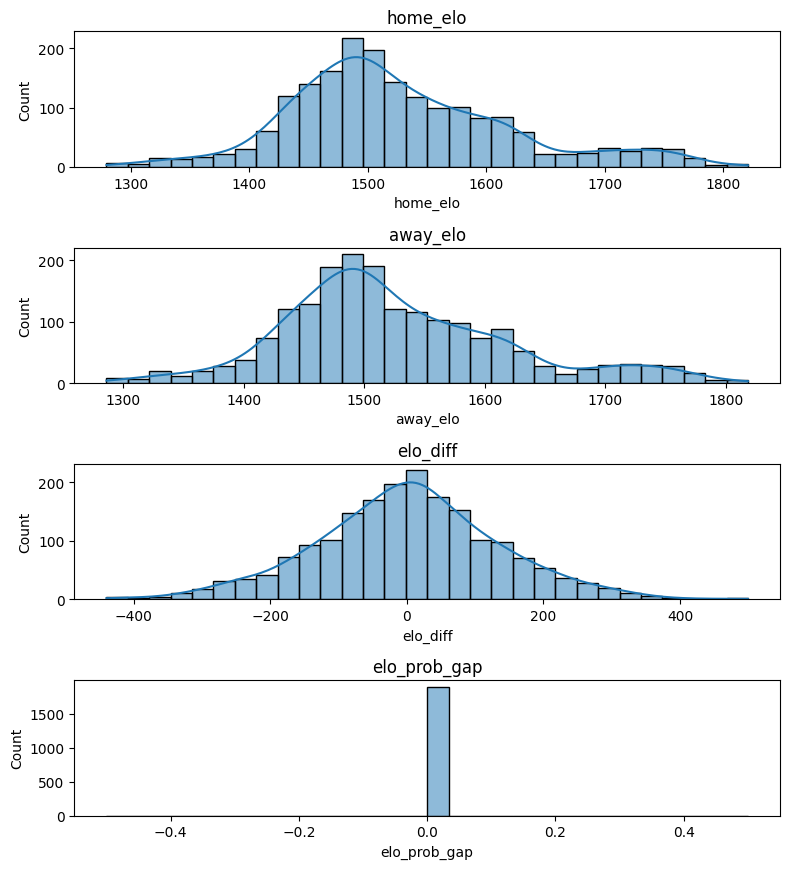

In [13]:
# Feature inspection
# Basic info
print("Columns:", len(df.columns))
print("Target distribution (target):")
if 'target' in df.columns:
    print(df['target'].value_counts(normalize=True).rename('pct').round(3))
else:
    print("WARNING: 'target' column missing")

# Missingness summary (top 10)
missing = df.isna().mean().sort_values(ascending=False)
print("Top missing cols:")
print(missing.head(10))

# Numeric summary
numeric_cols = df.select_dtypes(include=["number"]).columns
display(df[numeric_cols].describe().T.head(15))

# Correlation heatmap (sample subset to keep rendering light)
plt.figure(figsize=(10,6))
subset_cols = list(numeric_cols[:20])  # first 20 numeric
sns.heatmap(df[subset_cols].corr(numeric_only=True), cmap='coolwarm', center=0)
plt.title("Correlation (subset)")
plt.show()

# Distribution of a few engineered features
cols_plot = [c for c in numeric_cols if any(k in c.lower() for k in ["elo", "rolling", "implied"])][:6]
fig, axs = plt.subplots(len(cols_plot), 1, figsize=(8, 2.2*len(cols_plot)))
for ax, c in zip(axs, cols_plot):
    sns.histplot(df[c], ax=ax, kde=True, bins=30)
    ax.set_title(c)
plt.tight_layout()
plt.show()

## 5. Train Models
Train Logistic Regression (optionally calibrated) and HistGradientBoosting (HGB).

In [14]:
# Train models
from sklearn.calibration import CalibratedClassifierCV

TARGET_COL = 'target'

# Recompute feature column groups using model definitions
numeric_cols_model = [c for c in model_mod.NUMERIC if c in df.columns and df[c].notna().any()]
categ_cols_model = [c for c in model_mod.CATEG if c in df.columns]
print(f"Numeric features: {len(numeric_cols_model)} | Categorical: {len(categ_cols_model)}")

# Chronological split (80/20)
df_sorted = df.sort_values('Date') if 'Date' in df.columns else df.copy()
split_idx = int(len(df_sorted) * 0.8)
train_df = df_sorted.iloc[:split_idx]
valid_df = df_sorted.iloc[split_idx:]

X_train = train_df[numeric_cols_model + categ_cols_model]
y_train = train_df[TARGET_COL]
X_valid = valid_df[numeric_cols_model + categ_cols_model]
y_valid = valid_df[TARGET_COL]
print(f"Train size: {X_train.shape} | Valid size: {X_valid.shape}")

# Build pipelines via internal helper (_pipe)
logreg = model_mod._pipe(numeric_cols_model, categ_cols_model, model_type='logreg')
logreg.fit(X_train, y_train)

hgb = model_mod._pipe(numeric_cols_model, categ_cols_model, model_type='hgb')
hgb.fit(X_train, y_train)

calibrated_logreg = CalibratedClassifierCV(
    model_mod._pipe(numeric_cols_model, categ_cols_model, model_type='logreg'),
    cv=3,
    method='isotonic',
)
calibrated_logreg.fit(X_train, y_train)

MODELS = {
    'logreg': logreg,
    'logreg_cal': calibrated_logreg,
    'hgb': hgb,
}
print({k: type(v).__name__ for k, v in MODELS.items()})

Numeric features: 19 | Categorical: 2
Train size: (1520, 21) | Valid size: (380, 21)


/Users/r39132/Projects/predict-epl-match-winner/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/r39132/Projects/predict-epl-match-winner/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as sho

{'logreg': 'Pipeline', 'logreg_cal': 'CalibratedClassifierCV', 'hgb': 'Pipeline'}


/Users/r39132/Projects/predict-epl-match-winner/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Diagnostic: logistic regression iterations & potential refit with higher max_iter
from sklearn.linear_model import LogisticRegression

logreg_clf = logreg.named_steps['clf'] if 'logreg' in MODELS else None
if logreg_clf and isinstance(logreg_clf, LogisticRegression):
    print('Original max_iter:', logreg_clf.max_iter)
    print('Solver:', logreg_clf.solver)
    print('n_iter_ per class (one-vs-rest):', getattr(logreg_clf, 'n_iter_', 'NA'))
    # Heuristic: if any class hit >= 0.95 * max_iter, consider increasing
    if hasattr(logreg_clf, 'n_iter_') and (logreg_clf.n_iter_.max() >= 0.95 * logreg_clf.max_iter):
        new_max = int(logreg_clf.max_iter * 1.5)
        print(f"Model likely hit iteration cap; refitting with max_iter={new_max} for convergence margin...")
        logreg_refit = model_mod._pipe(numeric_cols_model, categ_cols_model, model_type='logreg', max_iter=new_max)
        logreg_refit.fit(X_train, y_train)
        MODELS['logreg_refit'] = logreg_refit
        print('Refit complete. New n_iter_:', logreg_refit.named_steps['clf'].n_iter_)
else:
    print('Logistic regression pipeline not found for diagnostics.')

## 6. Evaluate Models
Compute accuracy, macro F1, confusion matrix, classification report, ROC-AUC macro (OVR).


Model: logreg
Accuracy: 0.4921  Macro F1: 0.3772  ROC-AUC(macro): 0.6351110200956779
              precision    recall  f1-score   support

           A       0.57      0.42      0.48       132
           D       0.14      0.02      0.04        93
           H       0.48      0.84      0.61       155

    accuracy                           0.49       380
   macro avg       0.40      0.43      0.38       380
weighted avg       0.43      0.49      0.43       380



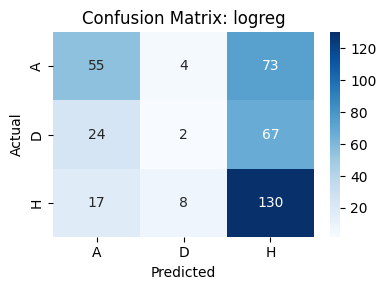


Model: logreg_cal
Accuracy: 0.5079  Macro F1: 0.3676  ROC-AUC(macro): 0.6275987490959954
              precision    recall  f1-score   support

           A       0.58      0.39      0.47       132
           D       0.00      0.00      0.00        93
           H       0.48      0.91      0.63       155

    accuracy                           0.51       380
   macro avg       0.36      0.43      0.37       380
weighted avg       0.40      0.51      0.42       380



/Users/r39132/Projects/predict-epl-match-winner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/r39132/Projects/predict-epl-match-winner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/r39132/Projects/predict-epl-match-winner/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

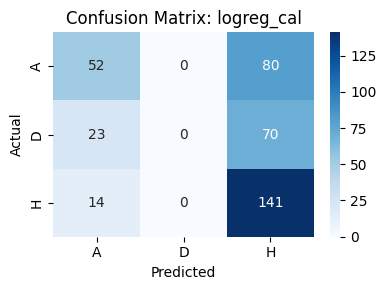


Model: hgb
Accuracy: 0.4895  Macro F1: 0.4333  ROC-AUC(macro): 0.6392869649437313
              precision    recall  f1-score   support

           A       0.56      0.49      0.52       132
           D       0.27      0.15      0.19        93
           H       0.51      0.69      0.58       155

    accuracy                           0.49       380
   macro avg       0.44      0.44      0.43       380
weighted avg       0.47      0.49      0.47       380



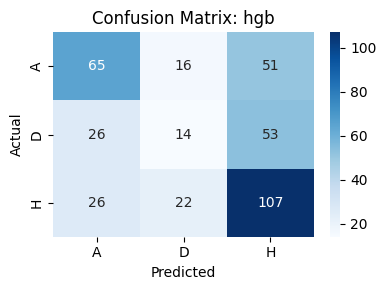


Summary:


,model,accuracy,f1_macro,roc_auc_macro
2,hgb,0.489474,0.433297,0.639287
0,logreg,0.492105,0.377201,0.635111
1,logreg_cal,0.507895,0.367625,0.627599


In [15]:
# Evaluation
results = []
classes = sorted(y_train.unique())

for name, mdl in MODELS.items():
    y_pred = mdl.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    f1_macro = f1_score(y_valid, y_pred, average='macro')
    try:
        proba = mdl.predict_proba(X_valid)
        # One-vs-rest macro AUC (requires at least two classes present in y_valid)
        if len(set(y_valid)) > 1:
            y_valid_bin = pd.get_dummies(y_valid)
            # Align columns to model classes
            y_valid_bin = y_valid_bin.reindex(columns=mdl.classes_, fill_value=0)
            auc_macro = roc_auc_score(y_valid_bin, proba, multi_class='ovr')
        else:
            auc_macro = np.nan
    except Exception:
        auc_macro = np.nan
    results.append({'model': name, 'accuracy': acc, 'f1_macro': f1_macro, 'roc_auc_macro': auc_macro})
    print(f"\nModel: {name}\nAccuracy: {acc:.4f}  Macro F1: {f1_macro:.4f}  ROC-AUC(macro): {auc_macro if not np.isnan(auc_macro) else 'nan'}")
    print(classification_report(y_valid, y_pred))

    cm = confusion_matrix(y_valid, y_pred, labels=classes)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

res_df = pd.DataFrame(results).sort_values('f1_macro', ascending=False)
print("\nSummary:")
res_df

## 7. Hyperparameter Tuning (Optional)
Illustrative quick search (small param grids) for Logistic Regression C and HGB learning rate.

In [16]:
# Quick (very small) tuning examples to keep runtime short

processed_dir = PROC_DIR

if hasattr(model_mod, 'tune_logreg'):
    logreg_tune = model_mod.tune_logreg(processed_dir)
    print('LogReg tuning result:', logreg_tune)
else:
    print('tune_logreg not available')

if hasattr(model_mod, 'tune_hgb'):
    hgb_tune = model_mod.tune_hgb(processed_dir, learning_rates=[0.05, 0.1], max_depths=[4,6], max_leaf_nodes_list=[31])
    print('HGB tuning result:', hgb_tune)
else:
    print('tune_hgb not available')

/Users/r39132/Projects/predict-epl-match-winner/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/r39132/Projects/predict-epl-match-winner/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as sho

LogReg tuning result: {'f1_macro': 0.41359399235564326, 'accuracy': 0.4316455696202532, 'C': 4.0}
HGB tuning result: {'f1_macro': 0.4376096198521415, 'accuracy': 0.4854430379746835, 'params': {'learning_rate': 0.05, 'max_depth': 6, 'max_leaf_nodes': 31}}
HGB tuning result: {'f1_macro': 0.4376096198521415, 'accuracy': 0.4854430379746835, 'params': {'learning_rate': 0.05, 'max_depth': 6, 'max_leaf_nodes': 31}}


## 8. Auto-Select Best Model
Uses macro F1 (primary) and accuracy tie-break to choose among candidates.

In [17]:
# Auto-select best model using library helper
selection = model_mod.select_and_train_best(PROC_DIR, ARTIFACTS_DIR)
print('Selection summary:', selection)

# Load persisted best model
best_pipeline, meta = model_mod.load_local_model(ARTIFACTS_DIR)
BEST_MODEL_NAME = meta.model_type
BEST_MODEL = best_pipeline
print('Loaded best model:', BEST_MODEL_NAME)

# Construct res_df compatible summary for continuity (if earlier res_df exists)
if 'res_df' not in globals() and isinstance(selection, dict):
    res_df = pd.DataFrame([
        {'model': 'logreg', **selection.get('logreg_metrics', {})},
        {'model': 'hgb', **selection.get('hgb_metrics', {})},
    ]).sort_values('f1_macro', ascending=False)
res_df

/Users/r39132/Projects/predict-epl-match-winner/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/r39132/Projects/predict-epl-match-winner/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as sho

Selection summary: {'chosen_model': 'hgb', 'chosen_metrics': {'accuracy': 0.4854430379746835, 'f1_macro': 0.4376096198521415}, 'logreg_metrics': {'accuracy': 0.4550632911392405, 'f1_macro': 0.434876170916154}, 'hgb_metrics': {'accuracy': 0.4854430379746835, 'f1_macro': 0.4376096198521415}, 'hgb_params': {}, 'calibrated': False}
Loaded best model: hgb
Loaded best model: hgb


,model,accuracy,f1_macro,roc_auc_macro
2,hgb,0.489474,0.433297,0.639287
0,logreg,0.492105,0.377201,0.635111
1,logreg_cal,0.507895,0.367625,0.627599


## 9. Prediction Example
Demonstrate using the best model to predict probabilities on recent matches.

In [18]:
# Use last 5 validation rows as a tiny prediction demo
sample = X_valid.tail(5) if 'X_valid' in globals() else pd.read_parquet(PROC_DIR / 'features.parquet').tail(5)
if 'BEST_MODEL' not in globals():
    BEST_MODEL, meta = model_mod.load_local_model(ARTIFACTS_DIR)

if hasattr(BEST_MODEL, 'predict_proba'):
    probs = BEST_MODEL.predict_proba(sample)
    pred_df = pd.DataFrame(probs, columns=[f"proba_{c}" for c in getattr(BEST_MODEL, 'classes_', [])])
else:
    preds = BEST_MODEL.predict(sample)
    pred_df = pd.DataFrame({'prediction': preds})

pred_df.index = sample.index
cols_to_show = [c for c in ['HomeTeam','AwayTeam','target'] if c in df.columns]
merged = pd.concat([df.loc[sample.index, cols_to_show], pred_df], axis=1, join='inner')
merged

,HomeTeam,AwayTeam,target,proba_A,proba_D,proba_H
1892,Ipswich,West Ham,A,0.978095,0.009676,0.012230
1891,Fulham,Man City,A,0.866239,0.094520,0.039241
1890,Bournemouth,Leicester,H,0.026598,0.025325,0.948078
1893,Liverpool,Crystal Palace,D,0.006927,0.861079,0.131994
1899,Wolves,Brentford,D,0.075001,0.859777,0.065222
